In [11]:
import matplotlib.pyplot as plt
import random
import json

In [12]:
#%matplotlib widget

In [13]:
from scipy import ndimage
import numpy as np
from copy import deepcopy
from PIL import Image
import IPython.display
from math import floor


In [14]:
import torch
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim  
import torchvision.transforms.functional as TF
import torchvision
import string
from torchvision import datasets, models, transforms

In [15]:
ENDWORD = '<END>'
STARTWORD = '<START>'
PADWORD = '<PAD>'
HEIGHT = 299
WIDTH = 299
INPUT_EMBEDDING = 300
HIDDEN_SIZE = 300
OUTPUT_EMBEDDING = 300

CAPTION_FILE = 'F:/caption_datasets/dataset_flickr8k.json'
IMAGE_DIR = 'C:/Users/Admin/Desktop/Flicker8k_Dataset/'

In [16]:
inception =models.inception_v3(pretrained=True)

In [17]:
inception

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [18]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [19]:
num_ftrs = inception.fc.in_features
num_ftrs

2048

In [20]:
set_parameter_requires_grad(inception, True)
num_ftrs = inception.fc.in_features
inception.fc = nn.Linear(num_ftrs,INPUT_EMBEDDING)

In [21]:
class Flickr8KImageCaptionDataset:
    
    def __init__(self):
        
        all_data = json.load(open(CAPTION_FILE, 'r'))
        all_data=all_data['images']
        
        self.training_data = []
        self.test_data = []
        self.w2i = {ENDWORD: 0, STARTWORD: 1}
        self.word_frequency = {ENDWORD: 0, STARTWORD: 0}
        self.i2w = {0: ENDWORD, 1: STARTWORD}
        self.tokens = 2 #END is default
        self.batch_index = 0
        
        for data in all_data:
            if(data['split']=='train'):
                self.training_data.append(data)
            else:
                self.test_data.append(data)
                
            for sentence in data['sentences']:
                for token in sentence['tokens']:
                    if(token not in self.w2i.keys()):
                        self.w2i[token] = self.tokens
                        self.i2w[self.tokens] = token
                        self.tokens +=1
                        self.word_frequency[token] = 1
                    else:
                        self.word_frequency[token] += 1
                        
    def image_to_tensor(self,filename):
        image = Image.open(filename)
        image = TF.resize(img=image, size=(HEIGHT,WIDTH))
       
        image = TF.to_tensor(pic=image)
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        
        return torch.unsqueeze(image,0)

    
    def return_train_batch(self): #size of 1 always
        
        #np.random.shuffle(self.training_data)
        for index in range(len(self.training_data)):
        
        #index = np.random.randint(len(self.training_data))
            sentence_index = np.random.randint(len(self.training_data[index]['sentences']))
            output_sentence_tokens = deepcopy(self.training_data[index]['sentences'][sentence_index]['tokens'])
            output_sentence_tokens.append(ENDWORD) #corresponds to end word

            image = self.image_to_tensor(IMAGE_DIR+self.training_data[index]['filename'])


            yield image, list(map(lambda x: self.w2i[x], output_sentence_tokens)), output_sentence_tokens, index
    
    def convert_tensor_to_word(self, output_tensor):
        output = F.log_softmax(output_tensor.detach().squeeze(), dim=0).numpy()
        return self.i2w[np.argmax(output)]
    
    def convert_sentence_to_tokens(self, sentence):
        
        tokens = sentence.split(" ")
        converted_tokens= list(map(lambda x: self.w2i[x], tokens))
        converted_tokens.append(self.w2i[ENDWORD])
        return converted_tokens
    
    def caption_image_greedy(self, net, image_filename, max_words=15): #non beam search, no temperature implemented
        net.eval()
        inception.eval()
        image_tensor = self.image_to_tensor(image_filename)
        hidden=None
        embedding=None
        words = []
    
        input_token = STARTWORD
        input_tensor = torch.tensor(self.w2i[input_token]).type(torch.LongTensor)
        
        
        for i in range(max_words):
            
            if(i==0):
                out, hidden=net(input_tensor, hidden=image_tensor, process_image=True)
            else:
                out, hidden=net(input_tensor, hidden)
                
            word = self.convert_tensor_to_word(out)
            
            input_token = self.w2i[word]
            input_tensor = torch.tensor(input_token).type(torch.LongTensor)
            
            
            if(word==ENDWORD):
                break
            else:
                words.append(word)

        return ' '.join(words)
    
    
    def forward_beam(self, net, hidden, process_image, partial_sentences, sentences, topn_words=5, max_sentences=10):
        
        max_words = 50
        
        hidden_index = {}
        
        while(sentences<max_sentences):
            
            #print("Sentences: ",sentences)
            
            new_partial_sentences = []
            new_partial_sentences_logp = []
            new_partial_avg_logp= []
            
            if(len(partial_sentences[-1][0])>max_words):
                break
            
            
        
            for partial_sentence in partial_sentences:

                input_token = partial_sentence[0][-1]

                input_tensor = torch.tensor(self.w2i[input_token]).type(torch.FloatTensor)

                if(partial_sentence[0][-1]==STARTWORD):
                    out, hidden=net(input_tensor, hidden, process_image=True)
                else:
                    out, hidden=net(input_tensor, torch.tensor(hidden_index[input_token]))

                #take first topn words and add as children to root

                out = F.log_softmax(out.detach().squeeze(), dim=0).numpy()
                out_indexes = np.argsort(out)[::-1][:topn_words]

        
                for out_index in out_indexes:
                    
                    if(self.i2w[out_index]==ENDWORD):
                        sentences=sentences+1
                        
                    else:
                    
                        total_logp = float(out[out_index]) + partial_sentence[1]
                        new_partial_sentences_logp.append(total_logp)
                        new_partial_sentences.append([np.concatenate((partial_sentence[0], [self.i2w[out_index]])),total_logp])
                        
                        len_words = len(new_partial_sentences[-1][0])
                        
                        
                        
                        new_partial_avg_logp.append(total_logp/len_words)
                        
                        #print(self.i2w[out_index])
                        
                        hidden_index[self.i2w[out_index]] = deepcopy(hidden.detach().numpy())
                
        
            
                
            #select topn partial sentences
        
            top_indexes = np.argsort(new_partial_sentences_logp)[::-1][:topn_words]
            
            new_partial_sentences = np.array(new_partial_sentences)[top_indexes]
        
           
            partial_sentences = new_partial_sentences
            
            
            
            
        
        
            
        
            
        return partial_sentences
    
    def caption_image_beam_search(self, net, image_filename, topn_words=10, max_sentences=10):
        
        net.eval()
        inception.eval()
        image_tensor = self.image_to_tensor(image_filename)
        hidden=None
        embedding=None
        words = []
    
        
        sentences = 0
        partial_sentences = [[[STARTWORD], 0.0]]
        
        partial_sentences = self.forward_beam(net, image_tensor, True, partial_sentences, sentences,  topn_words, max_sentences)
    
        logp = []
        
        joined_sentences = []
    
        for partial_sentence in partial_sentences:
            
        
            joined_sentences.append([' '.join(partial_sentence[0][1:]),partial_sentence[1]])
            
            
                
        return joined_sentences

    def print_beam_caption(self, net, train_filename,num_captions=0):
        beam_sentences = f.caption_image_beam_search(net,train_filename)
        if(num_captions==0):
            num_captions=len(beam_sentences)
        for sentence in beam_sentences[:num_captions]:
            print(sentence[0]+" [",sentence[1], "]")
        

In [22]:
class IC_V6(nn.Module):
    
    # Fed image vector directly as hidden and fed words generated as inputs back to LSTM
    # Added an embedding layer between words input and GRU/LSTM
    
    def __init__(self, token_dict_size):
        super(IC_V6, self).__init__()
        
        #Input is an image of height 500, and width 500
        
        
        self.embedding_size = INPUT_EMBEDDING
        self.hidden_state_size = HIDDEN_SIZE
        self.token_dict_size = token_dict_size
        self.output_size = OUTPUT_EMBEDDING
        
        self.batchnorm = nn.BatchNorm1d(self.embedding_size)
        
        self.input_embedding = nn.Embedding(self.token_dict_size, self.embedding_size)
        
        self.embedding_dropout = nn.Dropout(p=0.22)
        self.gru_layers = 3
        
        self.gru = nn.GRU(input_size=self.embedding_size, hidden_size=self.hidden_state_size, num_layers=self.gru_layers, dropout=0.22)
        self.linear = nn.Linear(self.hidden_state_size, self.output_size)
        self.out = nn.Linear(self.output_size, token_dict_size)
        
    def forward(self, input_tokens, hidden, process_image=False, use_inception=True):
        
        
        """ 
        if(USE_GPU):
            device = torch.device('cuda')
        else:
        """
        device = torch.device('cpu')
        
        if(process_image):
            if(use_inception):
                inp=self.embedding_dropout(inception(hidden))
            else:
                inp=hidden
            
            hidden=torch.zeros((self.gru_layers,1, self.hidden_state_size))
        else:
            inp=self.embedding_dropout(self.input_embedding(input_tokens.view(1).type(torch.LongTensor).to(device)))
            
            
        
        hidden = hidden.view(self.gru_layers,1,-1)
        inp = inp.view(1,1,-1)
        
        out, hidden = self.gru(inp, hidden)
        out = self.out(self.linear(out))
        
        
        
        return out, hidden
    

In [23]:
f = Flickr8KImageCaptionDataset()

In [24]:
net = IC_V6(f.tokens)

In [25]:
net.eval()

IC_V6(
  (batchnorm): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_embedding): Embedding(8385, 300)
  (embedding_dropout): Dropout(p=0.22, inplace=False)
  (gru): GRU(300, 300, num_layers=3, dropout=0.22)
  (linear): Linear(in_features=300, out_features=300, bias=True)
  (out): Linear(in_features=300, out_features=8385, bias=True)
)

# Training of network

In [16]:
l = torch.nn.CrossEntropyLoss(reduction='none')

In [17]:
o = optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
epochs = 15

inception.eval()
net.train()

loss_so_far = 0.0

total_samples = len(f.training_data)

for epoch in range(epochs):
    
    for (image_tensor, tokens, _, index) in f.return_train_batch():
    
        o.zero_grad()
        net.zero_grad()



        words = []

        loss=0.


        input_token = f.w2i[STARTWORD]
        input_tensor = torch.tensor(input_token)


        for token in tokens:

            if(input_token==f.w2i[STARTWORD]):
                out, hidden=net(input_tensor, image_tensor, process_image=True)
            else:
                out, hidden=net(input_tensor, hidden)


            class_label = torch.tensor(token).view(1)

            input_token = token
            input_tensor = torch.tensor(input_token)


            out = out.squeeze().view(1,-1)

            loss += l(out,class_label)


        loss = loss/len(tokens)

        loss.backward()
        o.step()

        loss_so_far += loss.detach().item()

        if(np.random.rand()<0.002): #5% of cases
            print("Epoch: ",epoch, ", index: ", index," loss: ",round(loss.detach().item(),3)," | running avg loss: ", round(loss_so_far/((epoch*total_samples)+(index+1)),3))

            torch.save(net.state_dict(), 'F:/running_save_v6.pth')
            torch.save(net.state_dict(), 'F:/running_inception_save_v6.pth')

            net.eval()
           
            #test dataset
            #random_train_index = np.random.randint(len(f.training_data))
            random_train_index = index
            train_filename = IMAGE_DIR+f.training_data[random_train_index]['filename']
            print("Original caption: ")
            [print(x['raw'].lower()) for x in f.training_data[random_train_index]['sentences']]
            print("")
            print("Greedy caption:", f.caption_image_greedy(net,train_filename))
            print("")
            print("Beam caption:")
            f.print_beam_caption(net, train_filename, 3)
            #IPython.display.Image(filename=test_filename) 
            pil_im = Image.open(train_filename, 'r')
            plt.figure()
            plt.imshow(np.asarray(pil_im))
            plt.show()
            net.train()
    
    print("\n\n")
    print("==== EPOCH DONE. === ")
    print("\n\n")


In [ ]:
torch.save(net.state_dict(), 'F:/epochs_40_loss_2_841_v6.pth')
torch.save(inception.state_dict(), 'F:/inception_epochs_40.pth')

In [27]:
inception.load_state_dict(torch.load('F:/inception_40_epochs.pth'))

<All keys matched successfully>

In [29]:
net.load_state_dict(torch.load('F:/epochs_40_v6.pth'))

<All keys matched successfully>

Original caption:  a group of several people sitting on the floor inside of a building

Greedy caption: a group of people are sitting on a bench

Beam caption:
a group of people sit on the beach in a [ -10.943267634138465 ]
a group of people sit on the beach with a [ -11.09943955205381 ]
a group of people are sitting on a fountain with [ -11.132395615801215 ]
a group of people sit in a trampoline in a [ -11.28205000422895 ]
a group of people are sitting on a fountain near [ -11.60929929278791 ]
a group of people are sitting on a fountain at [ -11.6555241253227 ]
a group of people standing in a fountain with a [ -11.684383740648627 ]
a group of people are standing in a fountain at [ -11.68516575358808 ]
a group of people sit on the beach in front [ -12.003010084852576 ]
a group of people are standing in a fountain in [ -12.09609185718 ]


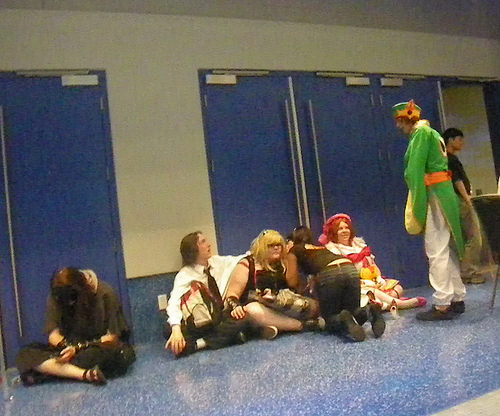

In [30]:
#traindataset
random_train_index =  np.random.randint(len(f.training_data))
train_filename = 'C:/Users/Admin/Desktop/Flicker8k_Dataset/'+f.training_data[random_train_index]['filename']
print("Original caption: ",f.training_data[random_train_index]['sentences'][0]['raw'])
print("")
print("Greedy caption:", f.caption_image_greedy(net,train_filename))
print("")
print("Beam caption:")
f.print_beam_caption(net, train_filename)

IPython.display.Image(filename=train_filename) 

Original caption:  A woman walks as she looks at her cellphone and others look on .

Greedy caption: a woman in a red shirt is walking past a crowd

Beam caption:
a group of people in front of [ -6.766417026519775 ]
a group of people stand in front [ -7.340497426688671 ]
a group of people stand in a [ -7.404425136744976 ]
a group of people are walking down [ -7.8543692752718925 ]
a group of people walking down a [ -7.963979832828045 ]
a group of people standing in a [ -8.016602091491222 ]
a group of people are standing in [ -8.066958360373974 ]
a group of people walking down the [ -8.370652787387371 ]
a group of people in a red [ -8.535795204341412 ]
a group of people are dancing in [ -8.59879969805479 ]


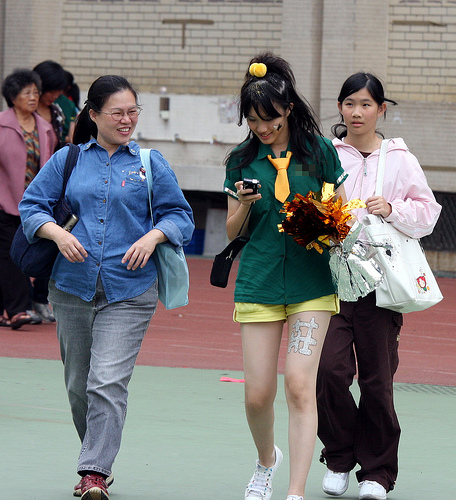

In [45]:
#test dataset
random_test_index = np.random.randint(len(f.test_data))
test_filename = IMAGE_DIR+f.test_data[random_test_index]['filename']
print("Original caption: ",f.test_data[random_test_index]['sentences'][0]['raw'])
print("")
print("Greedy caption:", f.caption_image_greedy(net,test_filename))
print("")
print("Beam caption:")
f.print_beam_caption(net, test_filename, 10)
IPython.display.Image(filename=test_filename) 

# Visualizations

In [31]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in xrange(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

In [32]:
frequency_threshold = 50 #the word should have appeared at least this many times for us to visualize

all_word_embeddings = []
all_words = []

for word in f.word_frequency.keys():
    if(f.word_frequency[word]>=frequency_threshold):
        all_word_embeddings.append(net.input_embedding(torch.tensor(f.w2i[word])).detach().numpy())
        all_words.append(word)

In [33]:
len(all_words)

701

In [34]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [35]:
X_2d = tsne.fit_transform(all_word_embeddings)

Number of labels: 10


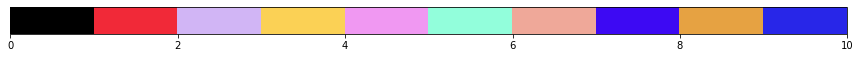

In [36]:
new_cmap = rand_cmap(10, type='bright', first_color_black=True, last_color_black=False, verbose=True)

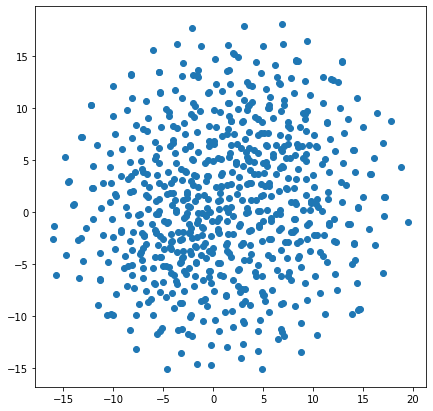

In [37]:
fig,ax = plt.subplots(figsize=(7, 7))
    
sc = plt.scatter(X_2d[:,0], X_2d[:,1])
#plt.legend()
#plt.show()

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->", color='red'))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format(" ".join([all_words[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor('white')
    annot.get_bbox_patch().set_alpha(0.9)


def hover(event):
    
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            
            
            update_annot(ind)
            
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
                
def onpick(event):
    ind = event.ind
    print(ind)
    label_pos_x = event.mouseevent.xdata
    label_pos_y = event.mouseevent.ydata
    annot.xy = (label_pos_x,label_pos_y)
    annot.set_text(y[ind])
    ax.figure.canvas.draw_idle()
    
    

fig.canvas.mpl_connect("motion_notify_event", hover)

#fig.canvas.mpl_connect('pick_event', onpick)
plt.show()

# Finding Top 5 similar words using cosine similarity

In [38]:
from scipy import spatial
def return_cosine_sorted(target_word_embedding):
    
    words = []
    cosines = []
    
    for i in range(len(all_word_embeddings)):
        cosines.append(1 - spatial.distance.cosine(target_word_embedding, all_word_embeddings[i]))
        
    sorted_indexes = np.argsort(cosines)[::-1]
    
    return np.vstack((np.array(all_words)[sorted_indexes], np.array(cosines)[sorted_indexes])).T

In [39]:
all_words[55]

'walking'

In [40]:
def return_similar_words(word, top_n=5):
    
    return return_cosine_sorted(return_embedding(word))[1:top_n+1]

In [41]:
def return_embedding(word):
    if(word in all_words):
        target_embedding_index = [i for i, s in enumerate(all_words) if word in s][0]
        return all_word_embeddings[target_embedding_index]
    else:
        return None

In [42]:
def return_analogy(source_word_1, source_word_2, target_word_1, top_n=5):
    
    em_sw_1 = return_embedding(source_word_1)
    em_sw_2 = return_embedding(source_word_2)
    em_tw_1 = return_embedding(target_word_1)
    
    if((em_sw_1 is None) | (em_sw_2 is None) | (em_tw_1 is None)):
        return 0
    
    target_embedding = em_tw_1 + (em_sw_2 - em_sw_1)
    return return_cosine_sorted(target_embedding)[1:top_n+1]
  


In [43]:
return_similar_words('playing')

array([['plays', '0.29516345262527466'],
       ['play', '0.22376133501529694'],
       ['ice', '0.1969175487756729'],
       ['carries', '0.1669851392507553'],
       ['have', '0.13986383378505707']], dtype='<U32')

In [44]:
return_analogy('man', 'men', 'woman')

array([['while', '0.1730809062719345'],
       ['women', '0.1722833812236786'],
       ['dresses', '0.16250142455101013'],
       ['shorts', '0.16069650650024414'],
       ['lady', '0.15847939252853394']], dtype='<U32')

In [45]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [46]:
import pickle
parsed_json=pickle.load(open('result.txt','rb'))
all_image_embeddings_temp=[]
all_image_filenames_temp=[]
for i in range(len(parsed_json)):
    all_image_filenames_temp.append(parsed_json[i]['filename'])
    all_image_embeddings_temp.append(parsed_json[i]['embeddings'])

In [47]:
all_image_embeddings=all_image_embeddings_temp[:]
all_image_filenames=all_image_filenames_temp[:]

In [48]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [49]:
from sklearn.manifold import TSNE
tsne_images = TSNE(n_components=2, random_state=0)


In [50]:
X_2d = tsne.fit_transform(np.squeeze(all_image_embeddings_temp))

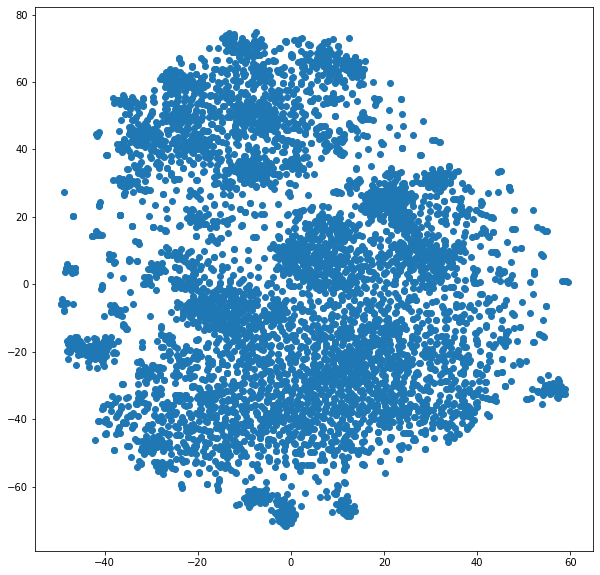

In [51]:
fig,ax = plt.subplots(figsize=(10, 10))
    
sc = plt.scatter(X_2d[:,0], X_2d[:,1])


annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->", color='red'))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    #text = "{}".format(" ".join([all_words[n] for n in ind["ind"]]))
    #annot.set_text(text)
    
    rho = 10 #how for to draw centers of new images
    total_radians = 2* np.pi
    num_images = len(ind["ind"])
    if(num_images > 4): #at max 4
        num_images=4
    radians_offset = total_radians/num_images
    
    
    for i in range(num_images):
        
        
        hovered_filename = 'C:/Users/Admin/Desktop/Flicker8k_Dataset/'+all_image_filenames_temp[ind["ind"][i]]
        arr_img = Image.open(hovered_filename, 'r')

        imagebox = OffsetImage(arr_img, zoom=0.3)
    #imagebox.image.axes = ax
    
        offset = pol2cart(rho, i*radians_offset)
        
       
    
        new_xy = (pos[0]+offset[0], pos[1]+offset[1])
        
        

        ab = AnnotationBbox(imagebox, new_xy)

        ax.add_artist(ab)
    
        annot.get_bbox_patch().set_facecolor('white')
        annot.get_bbox_patch().set_alpha(0.9)


def hover(event):
    
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            
            
            update_annot(ind)
            
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            
            if vis:
                annot.set_visible(False)
                remove_all_images()
                fig.canvas.draw_idle()

def remove_all_images():
    for obj in ax.findobj(match = type(AnnotationBbox(1, 1))):
    
        obj.remove()
    
    

fig.canvas.mpl_connect("motion_notify_event", hover)

#fig.canvas.mpl_connect('pick_event', onpick)

plt.show()

# Image to image

In [52]:
def plot_image(filename):
    pil_im = Image.open(filename, 'r')
    plt.figure()
    plt.imshow(np.asarray(pil_im))
    plt.show()

In [53]:
def return_similar_images(image_filename, top_n=5):
    
    return return_cosine_sorted_image(return_embedding_image(image_filename))[1:top_n+1]

In [54]:
def return_cosine_sorted_image(target_image_embedding):
    
    
    
    cosines = []
    
    for i in range(len(all_image_embeddings)):
        cosines.append(1 - spatial.distance.cosine(target_image_embedding, all_image_embeddings[i]))
        
    sorted_indexes = np.argsort(cosines)[::-1]
    
    return np.vstack((np.array(all_image_filenames)[sorted_indexes], np.array(cosines)[sorted_indexes])).T

In [55]:
def return_embedding_image(image_filename):
    return inception(f.image_to_tensor(image_filename)).detach().numpy().squeeze()

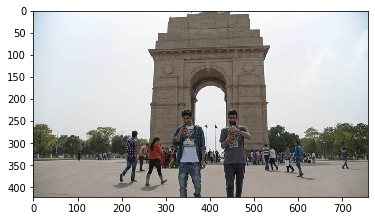

In [56]:
search_filename = 'F:/IndiaGate.jpg'
plot_image(search_filename)

In [57]:
similar_images = return_similar_images(search_filename)

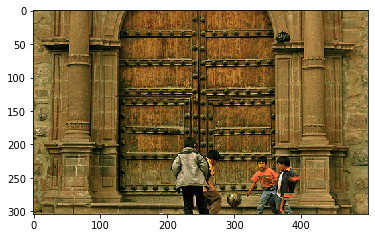

In [58]:
plot_image('C:/Users/Admin/Desktop/Flicker8k_Dataset/'+similar_images[0][0])

# Search via Captions

In [59]:
target_sentence = 'a dog jumping'
tokens= f.convert_sentence_to_tokens(target_sentence)

In [60]:
set_parameter_requires_grad(net, True)

In [61]:
embedding_tensor = torch.autograd.Variable(torch.randn(1,INPUT_EMBEDDING)*0.01, requires_grad=True)

In [62]:
l = torch.nn.CrossEntropyLoss(reduction='none')

In [63]:
print(embedding_tensor.shape)

torch.Size([1, 300])


==== Epoch:  0  loss:  12.851  | running avg loss:  12.851
[['548751378_c657401312.jpg' '0.15245266258716583']
 ['2839532455_36a7dc4758.jpg' '0.12965500354766846']
 ['2465497494_43d74df57c.jpg' '0.12335656583309174']]
==== Epoch:  10  loss:  9.598  | running avg loss:  11.032
==== Epoch:  20  loss:  9.012  | running avg loss:  10.181
==== Epoch:  30  loss:  8.592  | running avg loss:  9.728
==== Epoch:  40  loss:  8.266  | running avg loss:  9.404
==== Epoch:  50  loss:  8.048  | running avg loss:  9.156
==== Epoch:  60  loss:  7.895  | running avg loss:  8.96
==== Epoch:  70  loss:  7.763  | running avg loss:  8.8
==== Epoch:  80  loss:  7.639  | running avg loss:  8.664
==== Epoch:  90  loss:  7.524  | running avg loss:  8.544
==== Epoch:  100  loss:  7.421  | running avg loss:  8.437
[['2115631346_9585a479b0.jpg' '0.10956072062253952']
 ['2169951750_495820a215.jpg' '0.09380055218935013']
 ['2839532455_36a7dc4758.jpg' '0.08501918613910675']]
==== Epoch:  110  loss:  7.324  | running 

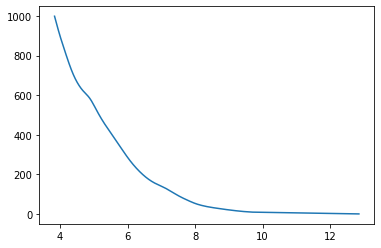

In [67]:
epochs = 1000

loss_so_far = 0.0
lsf=[]
lr = 0.001


with torch.autograd.set_detect_anomaly(True):

    for epoch in range(epochs):
        
        

        input_token = f.w2i[STARTWORD]
        input_tensor = torch.tensor(input_token)

        loss=0.

        for token in tokens:

            if(input_token==f.w2i[STARTWORD]):
                out, hidden=net(input_tensor, embedding_tensor, process_image=True, use_inception=False)
            else:
                out, hidden=net(input_tensor, hidden)


            class_label = torch.tensor(token).view(1)

            input_token = token
            input_tensor = torch.tensor(input_token)


            out = out.squeeze().view(1,-1)

            loss = loss + l(out,class_label)


        #loss = loss/len(tokens)

        loss.backward()

        #print(image_tensor.grad)
        
        embedding_tensor=  torch.autograd.Variable(embedding_tensor.clone() - lr * embedding_tensor.grad, requires_grad=True)
        

        loss_so_far+=loss.detach().item()
        lsf.append(loss.detach().item())

        if(epoch %10 ==0):
            print("==== Epoch: ",epoch, " loss: ",round(loss.detach().item(),3)," | running avg loss: ", round(loss_so_far/(epoch+1),3))
            if(epoch %100 ==0):
                similar_images = return_cosine_sorted_image(embedding_tensor.detach().numpy().squeeze())
                print(similar_images[:3])
                #plot_image('Flicker8k_Dataset/'+similar_images[0][0])
plt.plot(lsf,range(0,1000))   


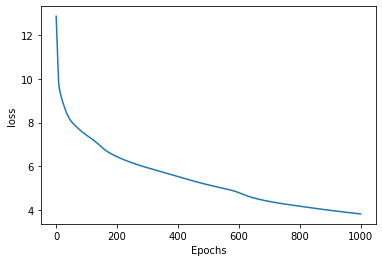

In [68]:
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.plot(range(0,1000),lsf)

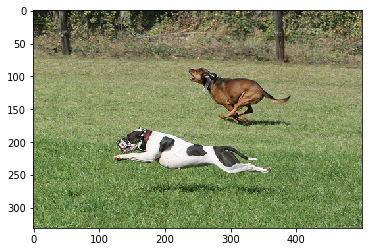

In [68]:
plot_image('C:/Users/Admin/Desktop/Flicker8k_Dataset/2084157130_f288e492e4.jpg')